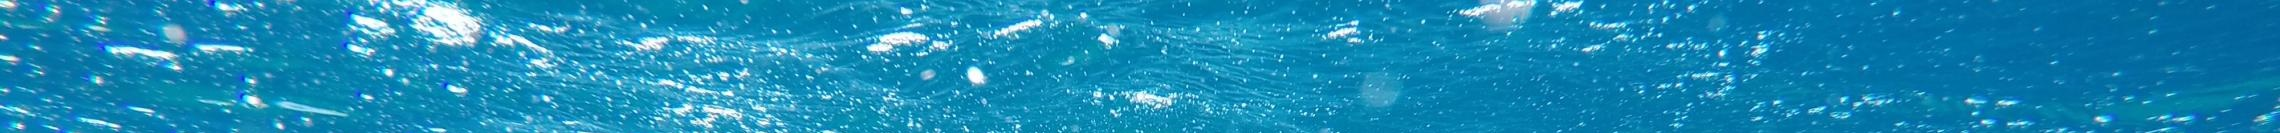
# Intel® oneAPI Hackathon for Open Innovation
## Machine Learning Challenge Track: Predict the quality of freshwater
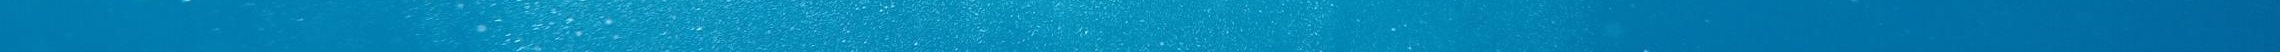

## Table of Contents <a id = 'top'/>
* [Utility Functions](#ufunc)
* [Data Load](#load)
* [Data Preprocessing](#preprocessing)
* [Exploratory Data Analysis](#eda)
* [Divide & Conquer: Clustering](#clustering)

[<div style = 'text-align:right'><button>Back to top</button></div>](#top)
## Utility Functions <a id='ufunc'/>

In [8]:
# DATA PROCESSING
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# DATA VISUALIZATION
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# MACHINE LEARNING
#
#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# MISCELLANEOUS
import gc
import warnings
warnings.filterwarnings('ignore')

[<div style = 'text-align:right'><button>Back to top</button></div>](#top)
## Data Load <a id='load'/>

In [9]:
PATH = "dataset.csv"
URL = 'https://s3-ap-southeast-1.amazonaws.com/he-public-data/datasetab75fb3.zip'
DTYPES = {'Index':'int32',
          'pH':'float32',
          'Iron':'float32', 
          'Nitrate':'float32', 
          'Chloride':'float32', 
          'Lead':'float64', 
          'Zinc':'float32', 
          'Color':'object',
          'Turbidity':'float32', 
          'Fluoride':'float32', 
          'Copper':'float32', 
          'Odor':'float32', 
          'Sulfate':'float64', 
          'Conductivity':'float64', 
          'Chlorine':'float64',
          'Manganese':'float32', 
          'Total Dissolved Solids':'float64',  
          'Source':'object',
          'Water Temperature':'float64',
          'Air Temperature':'float64',
          'Month':'object',
          'Day':'float16',
          'Time of Day':'float16',
          'Target':'float16',
         }
MONTHS = {'January':1, 
          'February':2, 
          'March':3, 
          'April':4, 
          'May':5, 
          'June':6, 
          'July':7, 
          'August':8, 
          'September':9, 
          'October':10, 
          'November':11, 
          'December':12,
         }

# Water Quality Standards-------------------------------------------

# http://cgwb.gov.in/documents/wq-standards.pdf
INDIAN_STANDARDS = {'pH':[6.5, 8.5, 8.5],
                    'Iron':[0, 0.3, 0.3], 
                    'Nitrate':[0, 45, 45], 
                    'Chloride':[0, 250, 1000], 
                    'Lead':[0, 0.01, 0.05], 
                    'Zinc':[0, 5, 15], 
                    'Color':[0, 5, 15],
                    'Turbidity':[0, 1, 5], 
                    'Fluoride':[0, 1, 1.5], 
                    'Copper':[0, 0.05, 1.5], 
                    'Odor':[0, 1, 2], #max5
                    'Sulfate':[0, 200, 400], 
                    'Conductivity':[], 
                    'Chlorine':[0, 0.2, 1],
                    'Manganese':[0, 0.1, 0.3], 
                    'Total Dissolved Solids':[0, 500, 2000],  
                   }
# https://en.wikipedia.org/wiki/Drinking_water_quality_standards
EU_STANDARDS = {'pH':[],
                'Iron':[0, 0.2, 0.2], 
                'Nitrate':[0, 50, 50], 
                'Chloride':[0, 250, 250], 
                'Lead':[0, 0.01, 0.01], 
                'Zinc':[], 
                'Color':[],
                'Turbidity':[], 
                'Fluoride':[0, 1.5, 1.5], 
                'Copper':[0, 2, 2], 
                'Odor':[], #max5
                'Sulfate':[], 
                'Conductivity':[0, 2500, 2500], 
                'Chlorine':[0, 0.2, 1],
                'Manganese':[0, 0.05, 0.05], 
                'Total Dissolved Solids':[],  
               }

In [10]:
%time
try:
    df = pd.read_csv(PATH, dtype = DTYPES)
except:
    download = input(prompt = 'Dataset could not be loaded from local storage. Download from AWS? (y/n)')
    if download == 'y':
        df = pd.read_csv(URL, compression='zip')
    else:
        print('Please save the dataset under Water_Quality/dataset.csv')

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11.9 µs


In [11]:
df.head(2)

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,0,8.332989,0.000083,8.605777,122.799774,3.713298e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.269945e-15,332.118789,NaN,NaN,43.493324,January,29.0,4.0,0.0
1,1,6.917863,0.000081,3.734167,227.029846,7.849262e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.024076e-07,284.641984,Lake,15.348981,71.220586,November,26.0,16.0,0.0


[<div style = 'text-align:right'><button>Back to top</button></div>](#top)
## Data Preprocessing <a id ='preprocessing'/>

In [12]:
df.set_index('Index', inplace = True)

In [13]:
df = df[df['Target'].isna() == False]

In [14]:
numeric_columns = list(df.select_dtypes(exclude = ['object']).columns)
df.sort_values(by = numeric_columns, inplace = True)

In [15]:
df[numeric_columns] = df[numeric_columns].replace((np.nan, ''), (None, None)).ffill(axis = 0, limit = None).bfill(axis = 0, limit = None)

In [16]:
object_columns = list(df.select_dtypes(include = ['object']).columns)
df[object_columns] = df[object_columns].replace((np.nan, ''), (None, None)).ffill(axis = 0).bfill(axis = 0, limit = None)

In [17]:
assert df.isna().sum().max() == 0, "Null values treatment failed"

In [18]:
df['Month'] = df['Month'].apply(lambda m: MONTHS[m])

In [19]:
print(f'Cleared {gc.collect()} unreachable objects.')

Cleared 12 unreachable objects.


## Feature Engineering

### One Hot Encoding

In [20]:
df = pd.get_dummies(df)

### Encoding prescribed standards

In [21]:
for parameter in INDIAN_STANDARDS.keys():
    if len(INDIAN_STANDARDS[parameter]) > 0:
        try:
            df["unacceptable_ind_"+parameter] = df[parameter].apply(lambda test_result:int((test_result > INDIAN_STANDARDS[parameter][-1]) or 
                                                                                           (test_result < INDIAN_STANDARDS[parameter][0])))
        except:
            pass

In [22]:
df['IND_violations'] = sum([df[col] for col in df.columns if 'unacceptable_ind_' in col])

In [23]:
for parameter in EU_STANDARDS.keys():
    if len(EU_STANDARDS[parameter]) > 0:
        try:
            df["unacceptable_eu_"+parameter] = df[parameter].apply(lambda test_result:int((test_result > INDIAN_STANDARDS[parameter][-1]) or 
                                                                                          (test_result < INDIAN_STANDARDS[parameter][0])))
        except:
            pass

In [24]:
df['EU_violations'] = sum([df[col] for col in df.columns if 'unacceptable_eu_' in col])

These columns will be highly correlated. Better to drop.

In [25]:
#df.drop(columns = ([col for col in df.columns if 'unacceptable_eu_' in col]+['EU_violations']), inplace = True)

### Scaling Numerical Features

In [26]:
scaler = StandardScaler()

In [27]:
numeric_columns = [col for col in numeric_columns if col not in ['Target', 'Day', 'Time of Day']]

In [28]:
df[numeric_columns].head(2)

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Water Temperature,Air Temperature
Index,,,,,,,,,,,,,,,,,
1076671,1.057113,8.897444e-02,2.932969,179.414856,7.113136e-95,4.633523,2.826831,0.147625,0.789783,3.382370,400.876559,233.429223,3.613899,1.307722,474.388802,23.033571,46.266676
683915,2.058008,4.957906e-08,6.503298,179.414856,3.332297e-100,0.005027,0.739386,0.001863,0.159954,2.114582,94.705433,313.425982,5.503649,0.000003,200.335500,37.675591,70.151566


In [29]:
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [30]:
df[numeric_columns].head(2)

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Water Temperature,Air Temperature
Index,,,,,,,,,,,,,,,,,
1076671,-5.623459,-0.080304,-0.994229,-0.06927,-0.046492,1.997563,2.514453,-0.990644,0.461214,1.480471,3.699691,-1.008952,0.491010,2.532898,1.330874,0.340440,-0.760692
683915,-4.756680,-0.261636,0.102312,-0.06927,-0.046492,-1.000480,0.241119,-1.167545,-0.595670,0.293993,-0.745083,-0.587459,3.069845,-0.227878,-0.428476,1.626694,0.560097


### Encode time features as sine waves

In [31]:
time_features = ['Month', 'Day', 'Time of Day']

In [32]:
df[time_features].describe()

,Month,Day,Time of Day
count,1.210917e+06,1.210917e+06,1.210917e+06
mean,6.520368e+00,1.573174e+01,1.149173e+01
std,3.449229e+00,8.799568e+00,6.925218e+00
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,4.000000e+00,8.000000e+00,5.000000e+00
50%,7.000000e+00,1.600000e+01,1.100000e+01
75%,1.000000e+01,2.300000e+01,1.700000e+01
max,1.200000e+01,3.100000e+01,2.300000e+01


In [33]:
df['Time of Day'] = df['Time of Day'].apply(lambda v: np.sin( 2 * np.pi * v/24 ))

In [34]:
df['Day'] = df['Day'].apply(lambda v: np.sin( 2 * np.pi * (v-1)/31 ))

In [35]:
df['Month'] = df['Month'].apply(lambda v: np.sin( 2 * np.pi * (v-1)/12 ))

In [36]:
print(f'Cleared {gc.collect()} unreachable objects.')

Cleared 0 unreachable objects.


## Modelling

In [37]:
TF_PATH = 'models/Intel_oneDNN_TF_NeuralNet'
XGB_PATH = 'models/Intel_oneDAL_XGBoost'

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['Target']).values, df['Target'].values, test_size=0.1, random_state=42)

In [39]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0], random_state=42)

In [40]:
assert xgb.__version__=='1.4.2', 'Upgrade to Intel Optimized XGBoost version 1.4.2'

### XGBoostClassifier

#### Train Model

In [41]:
xgb_params = {
    'verbosity':                    0,
    'alpha':                        0.9,
    'max_bin':                      256,
    'learning_rate':                0.1,
    'subsample':                    1,
    'reg_lambda':                   1,
    "min_child_weight":             0,
    'max_depth':                    8,
    'max_leaves':                   2**8,
    'objective':                    'binary:logistic',
    'predictor':                    'cpu_predictor',
    'tree_method':                  'hist',
    'n_estimators':                1000
}

model_xgb= xgb.XGBClassifier(**xgb_params, scale_pos_weight = df.shape[0]/df.Target.sum() - 1, silent = True)
model_xgb.fit(X_train, y_train)

XGBClassifier(alpha=0.9, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_delta_step=0, max_depth=8,
              max_leaves=256, min_child_weight=0, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=12,
              num_parallel_tree=1, predictor='cpu_predictor', random_state=0,
              reg_alpha=0.899999976, reg_lambda=1,
              scale_pos_weight=2.3529846654815505, silent=True, subsample=1,
              tree_method='hist', validate_parameters=1, ...)

#### Test Model

In [42]:
result_predict_xgb_test = model_xgb.predict(X_test)

In [43]:
# Check model accuracy
acc = np.mean(y_test == result_predict_xgb_test)
print("Model accuracy =",acc)

Model accuracy = 0.8723202193373634


In [44]:
confusion_matrix(y_test, result_predict_xgb_test)

array([[70858, 14064],
       [ 1397, 34773]])

In [45]:
f1_score(y_test, result_predict_xgb_test)

0.8181208606350067

### Hyperparameter Tuning

In [46]:
params = {
        'min_child_weight': [5,],
        'gamma': [0.5, 0.1,],
        'colsample_bytree': [1, 0.8],
        'max_depth': [10, 15, 20]
        }

In [ ]:
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(model_xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=1, random_state=42)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/u185314/.local/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/u185314/.local/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/u185314/.local/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/u185314/.local/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [ ]:
best_model_xgb = random_search.best_estimator_

In [ ]:
result_predict_xgb_test = best_model_xgb.predict(X_test)

In [ ]:
# Check model accuracy
acc = np.mean(y_test == result_predict_xgb_test)
print("Model accuracy =",acc)

In [ ]:
confusion_matrix(y_test, result_predict_xgb_test)

In [ ]:
f1_score(y_test, result_predict_xgb_test)

#### Save Model

In [47]:
model_xgb.save_model(f'{XGB_PATH}/XGB Model')

#### Saving the results for Ensemble Learning

In [48]:
saved_model = xgb.XGBClassifier()
saved_model.load_model(f'{XGB_PATH}/XGB Model')

In [49]:
result_predict_xgb_test = saved_model.predict(X_test)
result_predict_xgb_train = saved_model.predict(X_train)

In [50]:
result = pd.DataFrame(result_predict_xgb_train)
result_test = pd.DataFrame(result_predict_xgb_test)
result

,0
0,0.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
1089820,1.0
1089821,0.0
1089822,0.0
1089823,0.0


In [51]:
result.rename(columns = {0:"xgb"}, inplace = True)
result_test.rename(columns = {0:"xgb"}, inplace = True)
result_test

,xgb
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
121087,1.0
121088,1.0
121089,1.0
121090,1.0


In [52]:
DATASET_PATH = 'Intermediate_datasets/xgb'

In [53]:
result.to_csv(f'{DATASET_PATH}/Result.csv', index = False)
result_test.to_csv(f'{DATASET_PATH}/Result_Test.csv', index = False)